In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
PATH = 'pedestrian'
N = 60
# BUFOR_SIZE = 30

In [3]:
f = open(f'{PATH}/temporalROI.txt','r') 
line = f.readline()
roi_start , roi_end = line.split() 
roi_start = int(roi_start) 
roi_end = int(roi_end)

I_start = cv2.imread(f'{PATH}/input/in%06d.jpg' % roi_start)
HEIGHT, WIDTH, _ = I_start.shape

In [4]:
NEIGHBORS = 8

def getRandomNeighborCoordinate(i, width):
    while True:
        rand_i = np.random.randint(i-NEIGHBORS, i+NEIGHBORS+1)
        rand_i = max(0, rand_i)
        rand_i = min(width-1, rand_i)
        if rand_i != i:
            return rand_i
        

In [5]:
def vibe(img, samples=None):
    N = 20
    R = 20
    bg_min = 2
    amount_of_random_sampling = 16
    HEIGHT, WIDTH = img.shape
    if samples is None:
        samples = np.zeros((HEIGHT, WIDTH, N), dtype=np.uint8)
    seg_map = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
    background = 0
    foreground = 255
    for y in range(HEIGHT):
        for x in range(WIDTH):
            count, index, dist = 0, 0, 0
            while count < amount_of_random_sampling and index < N:
                dist = np.linalg.norm(samples[y, x, index] - img[y, x])
                if dist < R:
                    count += 1
                index += 1
            if count >= bg_min:
                seg_map[y, x] = background
                rand = np.random.randint(0, amount_of_random_sampling)
                if rand == 0:
                    rand = np.random.randint(0, N)
                    samples[y, x, rand] = img[y, x]
                rand = np.random.randint(0, amount_of_random_sampling)
                if rand == 0:
                    xNg = getRandomNeighborCoordinate(x, WIDTH)
                    yNg = getRandomNeighborCoordinate(y, HEIGHT)
                    rand = np.random.randint(0, N)
                    samples[yNg, xNg, rand] = img[y, x]
            else:
                seg_map[y, x] = foreground
    
    return seg_map, samples

def initialize_background_model(I_gray, N=20):
    height = I_gray.shape[0]
    width = I_gray.shape[1]
    samples = np.zeros((height,width,N))
    for y in range(0, height):
        for x in range(0, width):
            for n in range(N):
                ry = getRandomNeighborCoordinate(y, height)
                rx = getRandomNeighborCoordinate(x, width)
                samples[y, x, n] = I_gray[ry, rx]
    return samples

Text(0.5, 1.0, 'Samples')

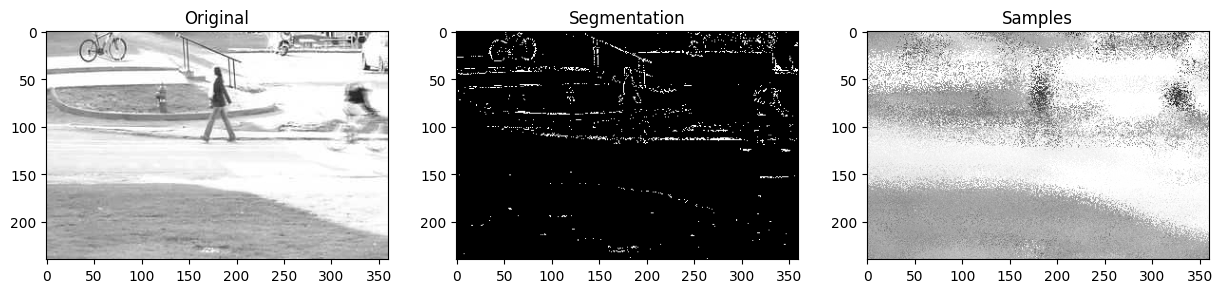

In [6]:
I_start = cv2.imread(f'{PATH}/input/in%06d.jpg' % 500, cv2.IMREAD_GRAYSCALE)
samples = initialize_background_model(I_start)
seg_map, samples = vibe(I_start, samples)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(I_start, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(seg_map, cmap='gray')
ax[1].set_title('Segmentation')
ax[2].imshow(samples[:,:,0], cmap='gray')
ax[2].set_title('Samples')

In [7]:
def faster_vibe(img, samples=None):
    N = 20
    R = 20
    bg_min = 2
    amount_of_random_sampling = 16
    HEIGHT, WIDTH = img.shape
    if samples is None:
        samples = initialize_background_model_faster(img, N)
    seg_map = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
    background = 0
    foreground = 255

    dists = np.abs(samples - img[:, :, np.newaxis])


    close_samples = dists < R
    counts = np.sum(close_samples, axis=-1)

    seg_map[counts < bg_min] = foreground
    seg_map[counts >= bg_min] = background


    rand = np.random.randint(0, amount_of_random_sampling, size=(HEIGHT, WIDTH))
    to_update = rand == 0
    rand = np.random.randint(0, N, size=(HEIGHT, WIDTH))
    samples[to_update, rand[to_update]] = img[to_update]

    xNg = (np.random.randint(-NEIGHBORS, NEIGHBORS + 1, size=(HEIGHT, WIDTH)) + np.arange(WIDTH))
    xNg = np.clip(xNg, 0, WIDTH - 1)
    yNg = (np.random.randint(-1, 2, size=(HEIGHT, WIDTH)) + np.arange(HEIGHT)[:, np.newaxis])
    yNg = np.clip(yNg, 0, HEIGHT - 1)
    rand = np.random.randint(0, N, size=(HEIGHT, WIDTH))
    samples[yNg, xNg, rand] = img

    return seg_map, samples


def initialize_background_model_faster(I_gray, N=20):
    I_gray = cv2.imread(f'{PATH}/input/in%06d.jpg' % 500, cv2.IMREAD_GRAYSCALE)
    N = 20
    height, width = I_gray.shape
    samples = np.zeros((height, width, N))

    rand_y = np.random.randint(-NEIGHBORS, NEIGHBORS + 1, size=(height, width, N))
    rand_x = np.random.randint(-NEIGHBORS, NEIGHBORS + 1, size=(height, width, N))

    y_indices = np.array([np.arange(height)] * width).T
    x_indices = np.array([np.arange(width)] * height)
    for n in range(N):
        rand_y_n = rand_y[:, :, n] + y_indices
        rand_x_n = rand_x[:, :, n] + x_indices
        rand_y_n = np.clip(rand_y_n, 0, height - 1)
        rand_x_n = np.clip(rand_x_n, 0, width - 1)
        samples[:, :, n] = I_gray[rand_y_n, rand_x_n]
    return samples

In [8]:
def gray_and_type(I):  # noqa: E741
    I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)  # noqa: E741
    I = I.astype('uint8')  # noqa: E741
    return I

def calculate_metrics(M, ref_mask, TP, TN, FP, FN):
    TP_M = np.logical_and((M==255), (ref_mask==255))
    TP = TP + np.sum(TP_M)

    TN_M = np.logical_and((M==0), (ref_mask==255))
    TN = TN + np.sum(TN_M)

    FP_M = np.logical_and((M==255), (ref_mask==0))
    FP = FP + np.sum(FP_M)

    FN_M = np.logical_and((M==0), (ref_mask==255))
    FN = FN + np.sum(FN_M)
    return TP, TN, FP, FN

In [9]:
I_start = cv2.imread(f'{PATH}/input/in%06d.jpg' % roi_start, cv2.IMREAD_GRAYSCALE)
samples = None
TP, TN, FP, FN = 0, 0, 0, 0

for i in range(roi_start+1, roi_end, 1):
    img = cv2.imread(f'{PATH}/input/in%06d.jpg' % i)
    IG = gray_and_type(img)

    ref_mask = cv2.imread(f'{PATH}/groundtruth/gt%06d.png' % i, cv2.IMREAD_GRAYSCALE)

    BG, samples = faster_vibe(IG, samples)


    TP, TN, FP, FN = calculate_metrics(BG, ref_mask, TP, TN, FP, FN)

    cv2.imshow('original', img)
    cv2.imshow('operation', samples[:,:,0])
    cv2.imshow('vibe', BG)
    cv2.waitKey(3)



P = TP / (TP + FP)
R = TP / (TP + FN)
F1 = 2 * P * R / (P + R)
print('ViBe precision: ', P, 'Recall: ', R, 'F1: ', F1)

ViBe precision:  0.6118032549321117 Recall:  0.45310660016516063 F1:  0.5206301575393848
